In [1]:
import keras as k, pandas as pd, pickle
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('../price_data.pickle','gzip')

In [3]:
btc = df[df['CC_symbol'] == 'BTC']
btc.sort_values('Timestamp')
btc.head()


,CC_USD_PRICE,CC_symbol,CMC_ID,Timestamp
112,7923.65,BTC,bitcoin,2018-02-02 12:32:36+00:00
258,7857.68,BTC,bitcoin,2018-02-02 12:42:02+00:00
538,7826.45,BTC,bitcoin,2018-02-02 12:44:41+00:00
698,8215.92,BTC,bitcoin,2018-02-02 12:56:36+00:00
814,8300.04,BTC,bitcoin,2018-02-02 13:00:22+00:00


In [4]:
WINDOW = 6
def look_back(df, window:int, var_name:str):
    for i in range(window):
        df[var_name+'-'+str(i+1)] = df[var_name].shift(-(i+1))
    return df

btc = look_back(btc,WINDOW, 'CC_USD_PRICE')
btc.dropna()
btc.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,CC_USD_PRICE,CC_symbol,CMC_ID,Timestamp,CC_USD_PRICE-1,CC_USD_PRICE-2,CC_USD_PRICE-3,CC_USD_PRICE-4,CC_USD_PRICE-5,CC_USD_PRICE-6
112,7923.65,BTC,bitcoin,2018-02-02 12:32:36+00:00,7857.68,7826.45,8215.92,8300.04,8434.37,8607.99
258,7857.68,BTC,bitcoin,2018-02-02 12:42:02+00:00,7826.45,8215.92,8300.04,8434.37,8607.99,8496.27
538,7826.45,BTC,bitcoin,2018-02-02 12:44:41+00:00,8215.92,8300.04,8434.37,8607.99,8496.27,8405.70
698,8215.92,BTC,bitcoin,2018-02-02 12:56:36+00:00,8300.04,8434.37,8607.99,8496.27,8405.70,8520.58
814,8300.04,BTC,bitcoin,2018-02-02 13:00:22+00:00,8434.37,8607.99,8496.27,8405.70,8520.58,8661.18


In [18]:
import numpy as np
arr = btc.values

def get_dataset(data, window):
    train = np.array([[x[0], *x[-window:] ] for x in data])
    train = train[~np.isnan(train).any(axis=1)]
    train_x = train[:,:window]
    train_y = train[:,window]
    return train_x, train_y

train_x, train_y = get_dataset(arr, WINDOW)

In [19]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)


In [20]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))


In [37]:
train_x

array([[[ 7923.65,  7857.68]],

       [[ 7857.68,  7826.45]],

       [[ 7826.45,  8215.92]],

       ...,

       [[10004.04,  9973.24]],

       [[ 9973.24,  9954.16]],

       [[ 9954.16,  9959.71]]])

In [21]:
model = k.models.Sequential()
model.add(k.layers.LSTM(4, input_shape=(1, WINDOW)))
model.add(k.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'acc'])
history = model.fit(train_x, train_y, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 11s - loss: 73174386.8462 - mean_absolute_error: 8515.4265 - acc: 0.0000e+00
Epoch 2/50
 - 10s - loss: 72885692.3692 - mean_absolute_error: 8498.4460 - acc: 0.0000e+00
Epoch 3/50
 - 10s - loss: 72605947.3330 - mean_absolute_error: 8481.9649 - acc: 0.0000e+00
Epoch 4/50
 - 10s - loss: 72327317.5965 - mean_absolute_error: 8465.5168 - acc: 0.0000e+00
Epoch 5/50
 - 10s - loss: 72049241.0754 - mean_absolute_error: 8449.0761 - acc: 0.0000e+00
Epoch 6/50
 - 10s - loss: 71771622.3967 - mean_absolute_error: 8432.6338 - acc: 0.0000e+00
Epoch 7/50
 - 10s - loss: 71494658.1665 - mean_absolute_error: 8416.1910 - acc: 0.0000e+00
Epoch 8/50
 - 12s - loss: 71218117.8697 - mean_absolute_error: 8399.7506 - acc: 0.0000e+00
Epoch 9/50
 - 13s - loss: 70942105.9461 - mean_absolute_error: 8383.3135 - acc: 0.0000e+00
Epoch 10/50
 - 12s - loss: 70666878.3555 - mean_absolute_error: 8366.8708 - acc: 0.0000e+00
Epoch 11/50
 - 13s - loss: 70391986.9726 - mean_absolute_error: 8350.4303 - acc: 0.0000e+

In [22]:
history = history.history

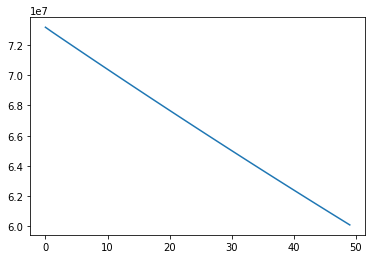

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history['loss'])